reference:
https://blog.amedama.jp/entry/hyperopt

In [10]:
# basic
import numpy as np
import pandas as pd
import pprint

# plot
#import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# model
from sklearn.svm import SVR

# optimization
from functools import partial
from sklearn.model_selection import KFold, cross_validate
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime

In [3]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocessing

## car name, car brand

In [4]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

In [5]:
train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

## horse power

In [6]:
# convert to float
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

# Standard Scaler

In [12]:
cols = ['displacement', 'horsepower', 'acceleration']

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

train_test[cols] = scaler.fit_transform(train_test[cols])

display(train_test)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
0,0,23.059782,6,-0.483685,0.143900,2815,1.195071,80,1,dodge aspen,dodge
1,3,17.674521,8,1.521800,1.333045,4456,-0.797646,72,1,dodge rampage,dodge
2,4,17.136353,8,1.063404,1.035759,2774,-0.933663,79,1,mercury cougar brougham,mercury
3,7,22.664666,6,1.999297,-0.599315,2190,-0.046689,71,1,pontiac j2000 se hatchback,pontiac
4,9,17.872018,8,2.276245,3.414047,2245,-2.535961,70,1,ford galaxie 500,ford
...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,0.328059,-0.004743,3870,0.033651,76,1,chevrolet nova,chevrolet
996,993,NaN,4,-0.483685,0.203358,2720,-0.751965,82,1,buick century limited,buick
997,996,NaN,8,1.216202,0.143900,2774,-0.905656,75,1,ford ltd,ford
998,998,NaN,4,-0.961181,-0.896601,2807,1.112525,77,1,dodge monaco brougham,dodge


# Encoding

In [13]:
cat_cols = ['cylinders', 'model year', 'origin', 'car name', 'car_brand']
train_test[cat_cols].nunique()

cylinders      3
model year    13
origin         3
car name      88
car_brand     23
dtype: int64

In [15]:
train_test = pd.get_dummies(
    train_test,
    columns=cat_cols, 
    sparse=False
)

display(train_test)

,id,mpg,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,...,car_brand_opel,car_brand_peugeot,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo
0,0,23.059782,-0.483685,0.143900,2815,1.195071,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,17.674521,1.521800,1.333045,4456,-0.797646,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,17.136353,1.063404,1.035759,2774,-0.933663,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,22.664666,1.999297,-0.599315,2190,-0.046689,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9,17.872018,2.276245,3.414047,2245,-2.535961,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,0.328059,-0.004743,3870,0.033651,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,993,NaN,-0.483685,0.203358,2720,-0.751965,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,996,NaN,1.216202,0.143900,2774,-0.905656,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,998,NaN,-0.961181,-0.896601,2807,1.112525,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create Model

In [16]:
test_treated = train_test[train_test['mpg'].isnull()].copy()
train_treated = train_test.dropna(subset=['mpg'], axis=0).copy()

train_X = train_treated.drop(['id', 'mpg'], axis=1)
train_y = train_treated['mpg']

In [17]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(X, y, args):
    model = SVR(**args)
    
    kf = KFold(n_splits=4, shuffle=True, random_state=1)
    
    score_func = {
        'score':make_scorer(RMSE)
    }
    
    cv_result = cross_validate(model, X=X, y=y, cv=kf, return_estimator=True, scoring=score_func)
    #models.append(cv_result['estimator'])
    
    return {
        'loss':cv_result['test_score'].mean(),
        'status':STATUS_OK,
        'params':args
    }

In [42]:
#models = []

f = partial(objective, train_X, train_y)

param_space = {
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(1e-8), high=np.log(10)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(1e-8), high=np.log(10)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(1e-8), high=np.log(10)
    )
}

trials=Trials()

best = fmin(
    fn=f,
    space=param_space, 
    algo=tpe.suggest,
    max_evals=500,
    trials=trials
)

100%|███████████████████████████████████████████████| 500/500 [01:12<00:00,  6.92trial/s, best loss: 4.134279429165644]


In [43]:
# trialsからスコアとパラメータを取り出し
result = [(i['loss'], i['params']) for i in trials.results]
# スコア昇順でソート
result.sort()
# スコアとパラメータそれぞれをリスト、辞書に
losses = [i[0] for i in result]
opt_params = [i[1] for i in result]
# スコアとパラメータをDataFrame化
opt_params_df = pd.concat([pd.Series(losses, name='loss'), pd.DataFrame(opt_params)], axis=1)
display(opt_params_df)

,loss,C,epsilon,gamma,kernel
0,4.134279,9.961506e+00,0.079178,7.579804e-02,rbf
1,4.137781,9.869637e+00,0.001783,8.172428e-02,rbf
2,4.138045,9.740027e+00,0.000013,7.637773e-02,rbf
3,4.141259,9.800864e+00,0.000128,6.657514e-02,rbf
4,4.142947,9.659319e+00,0.000074,8.451014e-02,rbf
...,...,...,...,...,...
495,7.664855,1.951499e-08,0.000018,1.070671e-03,rbf
496,7.664855,1.317558e-08,0.000074,7.298193e-03,rbf
497,7.664855,6.700723e-08,0.000016,3.135810e-08,rbf
498,7.664855,1.005336e-08,0.000017,3.524966e+00,rbf


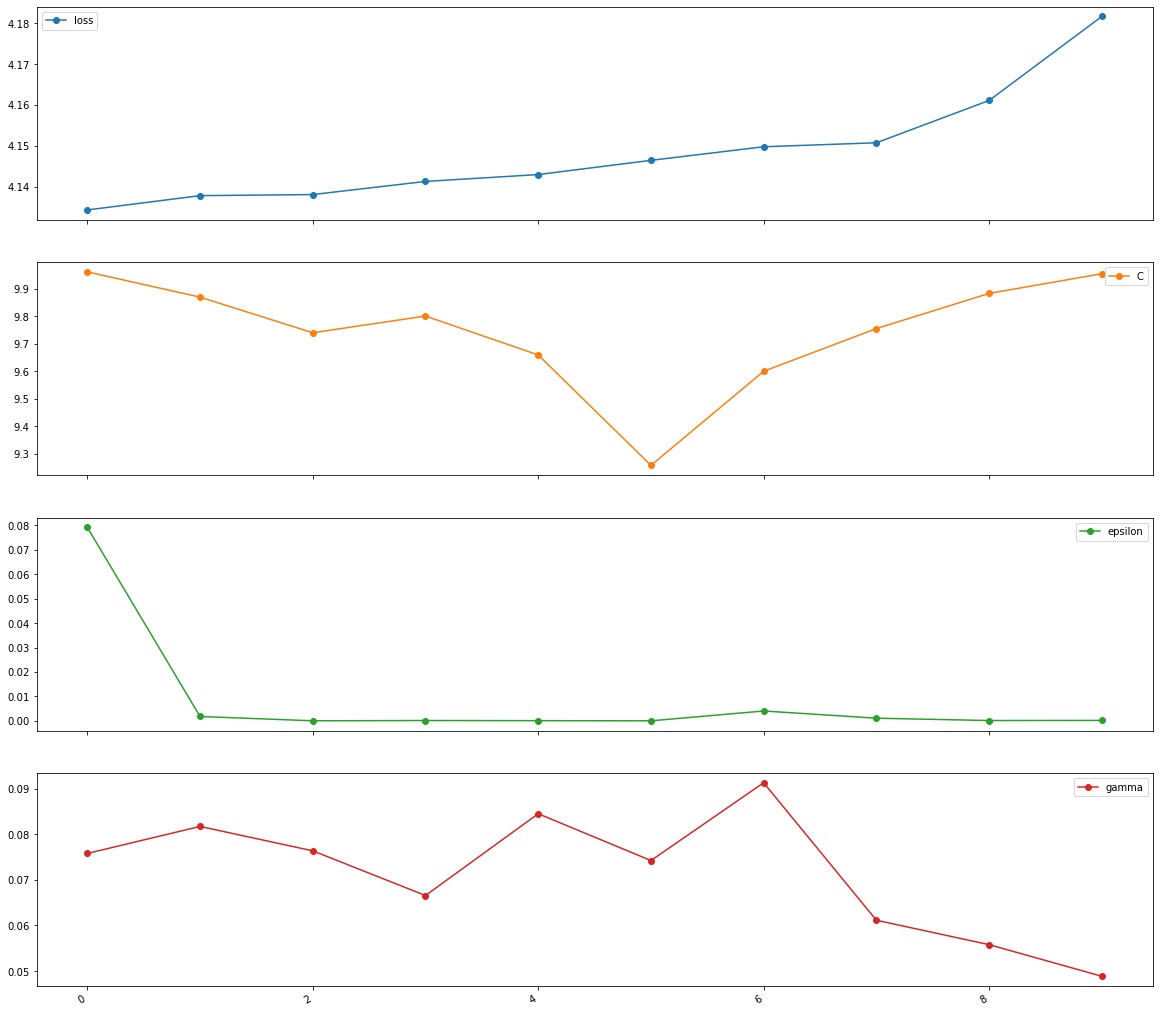

In [44]:
opt_params_df.iloc[:10, :4].plot.line(figsize=(20, 20), layout=(4, 1), marker='o', subplots=True)
plt.show()

In [45]:
# ベストスコアとそのときのパラメータを記録
best_loss = losses[0]
best_params = opt_params[0]

# Create Submission

In [46]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
submission = pd.DataFrame({'id':sample_sub.id})
importance_list = []

best_model = SVR(**best_params)
best_model.fit(train_X, train_y)
submission = pd.concat(
    [submission, pd.Series(best_model.predict(test_treated.drop(['id', 'mpg'], axis=1)), name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,35.830193
1,2,25.240345
2,5,27.288935
3,6,27.299814
4,8,23.227881
...,...,...
495,992,24.623387
496,993,23.669335
497,996,18.244859
498,998,27.288935


### Save files

In [47]:
# features
train_treated.to_pickle('../features/feature_train_' + dt + '_treated.pkl')
test_treated.to_pickle('../features/feature_test_' + dt + '_treated.pkl')

# submission
submission[['id', 'pred']].to_csv('../data/output/sub_' + dt + '_svr.csv', header=False, index=False)
# model
pickle.dump(best_model, open('../models/model_' + dt + '_svr.pickle', 'wb'))
# best parameter
pickle.dump(best_params, open('../logs/params_' + dt + '.pickle', 'wb'))
# best train score
pickle.dump(best_loss, open('../logs/logs_test_score' + dt + '.pickle', 'wb'))